###                                                          Shasta Valley Diversion Data An Processing Diversion Data Shasta Valley 


### **List of available files**
1. *Gis files* 
     * Land use data (has irrigation water source)
     * SiskiyouCanalsDitches.zip
     * IrrigationDistricts: Shapefile containing the service areas of irrigation districts
  
 2. *Excel files* 
    * Shasta water rights summary.xlsx
      Dataset transferred by SWRCB containing locations of points of diversion, inactive water rights, summer and winter start and end dates, 
     adjudication paragraph number, decree order, POU total acreage
    * Shasta_Valley_Diversion_Info.xlsx: 
      This is an older dataset from Davids Engineering. It contains the service area, source of the diversion, tract number in the watermaster maps, begin dates of summer and winter periods, active status, priority, and allotments for winter and summer
    * Shasta_Valley_Surface_Diversion_Summary 191114.xlsx:
      Older data from Davids Engineering. Total diversions reported by watermaster based on priority and annual summary reports from the Watermaster. Results provided by service area.
    * SSWD_diverions_info/SSWD_Diversion_Info_20190503.xlsx:
     Spreadsheet with diversion records provided by the Watermaster on 2019. Contains 661 records with information of Decree, Service Area, Source, Diversion Number, Decree Paragraph, Map No, Tract No, APN, Decreed Owner, Priority, Active status, Flow amount of water right. The APN of the POU is key to connect diversions with the parcels where water is being applied.
    * SSWD_diverions_info/KEY FOR DATA FILE.docx: Key for spreadsheet in cell above
  ```{code-cell} python

###  1. Shasta Water Rights Summary 

##### i. Visualizing the diversion points, subbasins, sfr, and irrigation ditch

#####  library 

In [34]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from openpyxl import load_workbook


#####  Data loading and Plotting 

In [36]:
# File paths
FILE_PATHS = {
    "rightsum": "D:/Shasta/20250130_diversions/Shasta water rights summary.xlsx",
    "landuse": "C:/Users/bisrat/Desktop/Shasta_project/gis_shasta/lulc_shasta_2020_lwa_wiz_sub_soil.shp",
    "stream": "D:/Shasta/shGIS/modflowfile/sfr.shp",
    "subbasin": "C:/Users/bisrat/Desktop/Shasta_project/gis_shasta/WBHDHU12_shasta.shp",
    "irrDis": "D:/Shasta/shGIS/modflowfile/IrrigationDistricts.shp",
    "irrCan": "D:/Shasta/shGIS/modflowfile/SiskiyouCanalDitches.shp",
    "parcel ": 'D:/Shasta/20250130_diversions/DiversionGIS/i15ParcelsAssessorLightbox.shp',
    "SSWD" : 'D:/Shasta/20250130_diversions/SSWD_diverions_info/SSWD_Diversion_Info_20190503.xlsx',
    'Davids' : 'D:/Shasta/20250130_diversions/Shasta_Valley_Surface_Diversion_Summary 191114.xlsx'

}

In [14]:

# Constants
rightsheet = "Sheet1"
rightnewsheet = "Sheet1_with_SubbasinID"  # New sheet name for updated data
PLOT_SETTINGS = {
    "figsize": (14, 10),
    "landuse": {"color": "lightgreen", "edgecolor": "gray", "alpha": 0.5, "label": "Land Use"},
    "subbasin": {"color": "none", "edgecolor": "purple", "linewidth": 1.5, "label": "Subbasins"},
    "irrDis": {"color": "none", "edgecolor": "red", "linewidth": 1.5, "label": "Irrigation Districts"},
    "irrCan": {"color": "none", "edgecolor": "black", "linewidth": 1.5, "label": "Irrigation Canals"},
    "stream": {"color": "blue", "linewidth": 1, "label": "Streams"},
    "points": {"color": "red", "markersize": 100, "edgecolor": "black", "marker": "o", "label": "Water Rights"}
}

def load_data():
    """Load shapefiles and Excel data."""
    gdf_landuse = gpd.read_file(FILE_PATHS["landuse"])
    gdf_streams = gpd.read_file(FILE_PATHS["stream"])
    gdf_subbasin = gpd.read_file(FILE_PATHS["subbasin"])
    gdf_irrDis = gpd.read_file(FILE_PATHS["irrDis"])
    gdf_irrCan = gpd.read_file(FILE_PATHS["irrCan"])
    
    df = pd.read_excel(FILE_PATHS["rightsum"], sheet_name=rightsheet)
    
    # Create a GeoDataFrame for points with valid coordinates
    valid_points = df.dropna(subset=['Longitude', 'Latitude']).copy()
    geometry = gpd.points_from_xy(valid_points['Longitude'], valid_points['Latitude'])
    gdf_points = gpd.GeoDataFrame(valid_points, geometry=geometry, crs="EPSG:4326")  # WGS84
    
    # Reproject points to match subbasin CRS
    gdf_points = gdf_points.to_crs(gdf_subbasin.crs)
    
    return gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points, df

def add_subbasin_info(gdf_points, gdf_subbasin, df):
    """Add subbasin ID to the DataFrame based on spatial join."""
    # Perform spatial join to find which subbasin each point belongs to
    joined_data = gpd.sjoin(gdf_points, gdf_subbasin, how="left", predicate="within")
    
    # Extract subbasin ID (column is named 'subbasinID' in the subbasin shapefile)
    df["SubbasinID"] = df.index.map(joined_data["subbasinID"])  # Map subbasin IDs back to the original DataFrame
    
    return df

def plot_data(gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points):
    """Plot shapefiles and overlay points."""
    fig, ax = plt.subplots(figsize=PLOT_SETTINGS["figsize"])
    
    # Plot shapefiles with labels
    if not gdf_landuse.empty:
        gdf_landuse.plot(ax=ax, **PLOT_SETTINGS["landuse"])
    if not gdf_subbasin.empty:
        gdf_subbasin.plot(ax=ax, **PLOT_SETTINGS["subbasin"])
    if not gdf_irrDis.empty:
        gdf_irrDis.plot(ax=ax, **PLOT_SETTINGS["irrDis"])
    if not gdf_irrCan.empty:
        gdf_irrCan.plot(ax=ax, **PLOT_SETTINGS["irrCan"])
    if not gdf_streams.empty:
        gdf_streams.plot(ax=ax, **PLOT_SETTINGS["stream"])
    
    # Overlay water rights points with label
    if not gdf_points.empty:
        gdf_points.plot(ax=ax, **PLOT_SETTINGS["points"])
    
    # Add plot details
    plt.title("Water Rights and Diversions in Shasta", fontsize=16, fontweight="bold")
    plt.xlabel("Longitude", fontsize=14)
    plt.ylabel("Latitude", fontsize=14)
    
    # Add grid
    ax.grid(True, linestyle="--", alpha=0.6)
    
    # Manually create legend handles
    legend_handles = [
        Patch(facecolor="lightgreen", edgecolor="gray", alpha=0.5, label="Land Use"),
        Patch(facecolor="none", edgecolor="purple", linewidth=1.5, label="Subbasins"),
        Patch(facecolor="none", edgecolor="red", linewidth=1.5, label="Irrigation Districts"),
        Patch(facecolor="none", edgecolor="green", linewidth=1.5, label="Irrigation Canals"),
        Line2D([0], [0], color="blue", linewidth=1, label="Streams"),
        Line2D([0], [0], color="red", marker="o", markersize=10, linestyle="None", label="Water Rights")
    ]
    
    # Add legend
    plt.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

##### -- Export the water right points to shape file

In [15]:
def export_to_shapefile(gdf_points, output_path):
    """Export the GeoDataFrame to a shapefile after filtering out invalid coordinates."""
    # Filter out rows with invalid (NaN, inf, -inf) coordinates
    valid_points = gdf_points[
        gdf_points.geometry.is_valid &  # Ensure geometry is valid
        gdf_points.geometry.notna() &   # Ensure geometry is not NaN
        gdf_points.geometry.apply(lambda geom: all(np.isfinite(coord) for coord in geom.coords[0]))  # Ensure coordinates are finite
    ]
    
    # Export only valid points to the shapefile
    valid_points.to_file(output_path, driver='ESRI Shapefile')
    print(f"Water rights points exported to {output_path}")

##### -- Main function 

c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


Land Use geometries: 1587
Subbasin geometries: 23
Irrigation Districts geometries: 7
Irrigation Canals geometries: 347
Stream geometries: 649
Water Rights points: 683


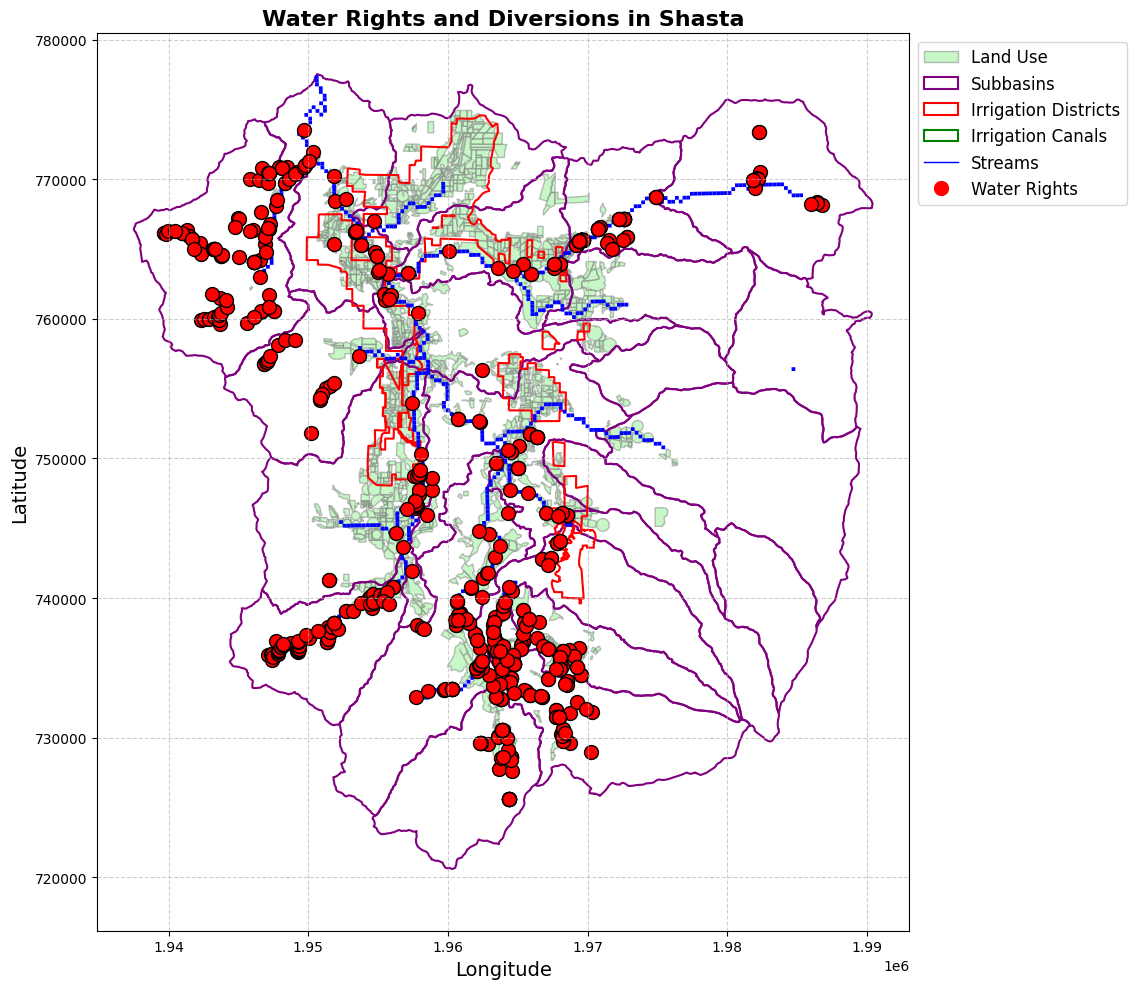

In [16]:
def main():
    """Main function to load data, add subbasin info, save updated data, and plot."""
    gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points, df = load_data()
    
    # Debug: Print the number of geometries in each GeoDataFrame
    print(f"Land Use geometries: {len(gdf_landuse)}")
    print(f"Subbasin geometries: {len(gdf_subbasin)}")
    print(f"Irrigation Districts geometries: {len(gdf_irrDis)}")
    print(f"Irrigation Canals geometries: {len(gdf_irrCan)}")
    print(f"Stream geometries: {len(gdf_streams)}")
    print(f"Water Rights points: {len(gdf_points)}")
    
    # Add subbasin information to the DataFrame
    df = add_subbasin_info(gdf_points, gdf_subbasin, df)
    # Export water rights points to a shapefile
    #output_shapefile_path = "D:/Shasta/20250130_diversions/DiversionGIS/water_rights_points.shp"  # Specify your desired output path
    #export_to_shapefile(gdf_points, output_shapefile_path)
    # Plot the data
    plot_data(gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points)

if __name__ == "__main__":
    main()

#### ii. Summary of diversion by subbasin 

c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


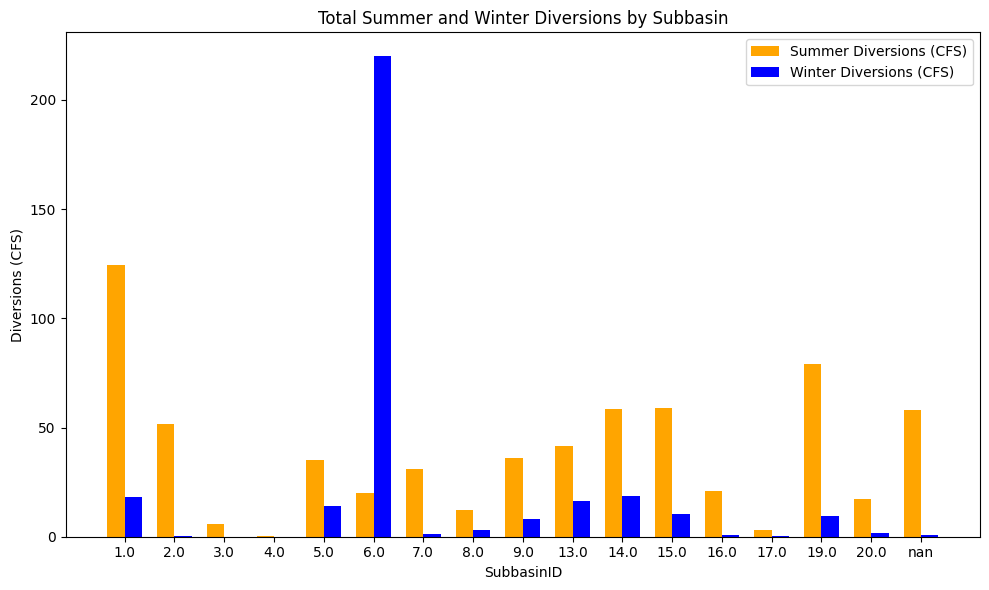

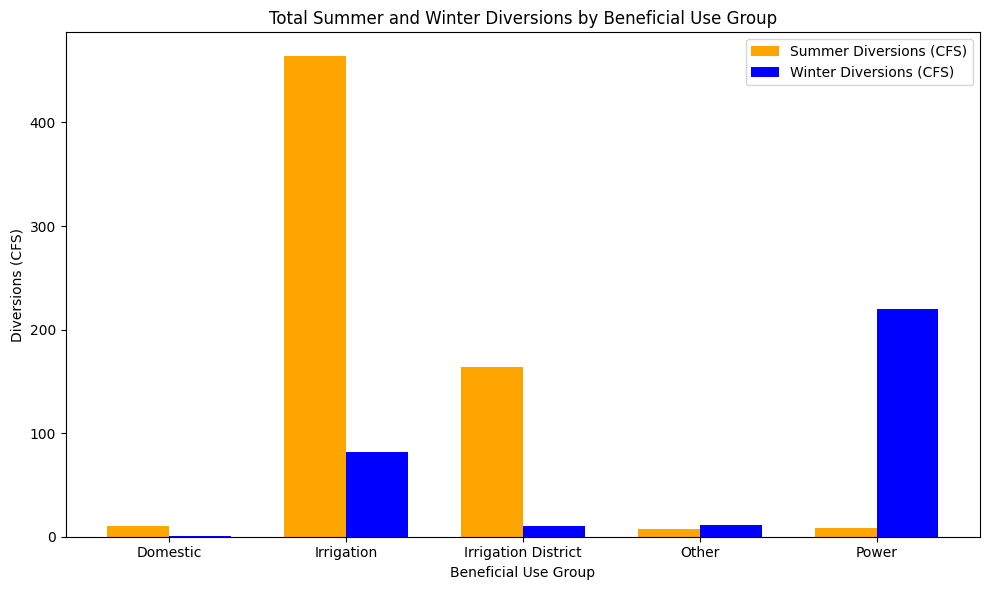

In [17]:
def summarize_diversions_by_subbasin(df):
    """Summarize summer and winter diversions by subbasin."""
    # Group by SubbasinID and sum Summer_CFS and Winter_CFS
    summary = df.groupby("SubbasinID", dropna=False).agg(
        Total_Summer_CFS=("Summer_CFS", "sum"),
        Total_Winter_CFS=("Winter_CFS", "sum")
    ).reset_index()
    
    return summary

def summarize_diversions_by_beneficial_use(df):
    """Summarize summer and winter diversions by beneficial use group."""
    # Group by Beneficial Use Group and sum Summer_CFS and Winter_CFS
    summary = df.groupby("Beneficial Use Group", dropna=False).agg(
        Total_Summer_CFS=("Summer_CFS", "sum"),
        Total_Winter_CFS=("Winter_CFS", "sum")
    ).reset_index()
    
    return summary

def plot_diversions(summary, title):
    """Plot summer and winter diversions by subbasin or beneficial use group."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Bar width and positions
    bar_width = 0.35
    x = summary.iloc[:, 0]  # First column (SubbasinID or Beneficial Use Group)
    x_index = range(len(x))
    
    # Plot bars for summer and winter diversions
    ax.bar([i - bar_width/2 for i in x_index], summary["Total_Summer_CFS"], width=bar_width, label="Summer Diversions (CFS)", color="orange")
    ax.bar([i + bar_width/2 for i in x_index], summary["Total_Winter_CFS"], width=bar_width, label="Winter Diversions (CFS)", color="blue")
    
    # Add plot details
    ax.set_xlabel(summary.columns[0])  # Use the first column name as the x-axis label
    ax.set_ylabel("Diversions (CFS)")
    ax.set_title(title)
    ax.set_xticks(x_index)
    ax.set_xticklabels(x)
    ax.legend()
    plt.tight_layout()
    plt.show()

def main():
    """Main function to load data, add subbasin info, summarize diversions, and plot."""
    gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points, df = load_data()
    
    # Add subbasin information to the DataFrame
    df = add_subbasin_info(gdf_points, gdf_subbasin, df)
    
    # Save the updated DataFrame to a new sheet
    #save_updated_data(df, FILE_PATHS["excel"], SHEET_NAME, NEW_SHEET_NAME)
    
    # Summarize diversions by subbasin
    subbasin_summary = summarize_diversions_by_subbasin(df)
    
    # Plot the summarized diversions by subbasin
    plot_diversions(subbasin_summary, "Total Summer and Winter Diversions by Subbasin")
    
    # Summarize diversions by beneficial use group
    beneficial_use_summary = summarize_diversions_by_beneficial_use(df)
    
    # Plot the summarized diversions by beneficial use group
    plot_diversions(beneficial_use_summary, "Total Summer and Winter Diversions by Beneficial Use Group")

if __name__ == "__main__":
    main()

#### Diversion by related id 

c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


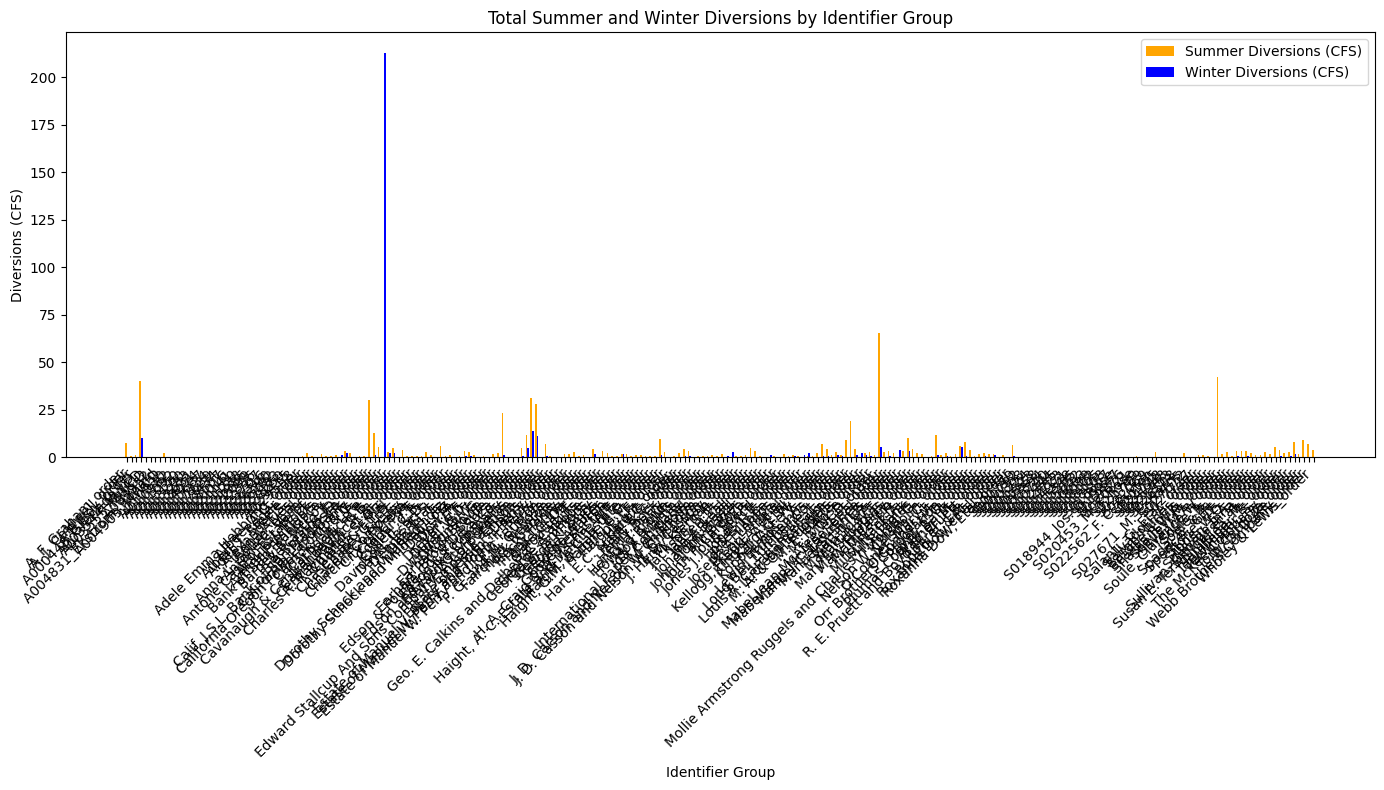

In [18]:
def extract_middle_part(identifier):
    """Extract the middle part of the Water Right Identifier."""
    parts = identifier.split("_")
    if len(parts) >= 3:
        # Combine the third and fourth parts (if they exist)
        return "_".join(parts[2:4])  # e.g., "A003544_MWCD"
    else:
        # If there are fewer than 3 parts, return the whole identifier
        return identifier

def summarize_diversions_by_identifier(df):
    """Summarize summer and winter diversions by the extracted middle part of the identifier."""
    # Extract the middle part of the Water Right Identifier
    df["Identifier_Group"] = df["Water Right Identifier"].apply(extract_middle_part)
    
    # Group by the extracted Identifier_Group and sum Summer_CFS and Winter_CFS
    summary = df.groupby("Identifier_Group", dropna=False).agg(
        Total_Summer_CFS=("Summer_CFS", "sum"),
        Total_Winter_CFS=("Winter_CFS", "sum")
    ).reset_index()
    
    return summary

def plot_identifier_diversions(summary):
    """Plot summer and winter diversions by the extracted identifier group."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Bar width and positions
    bar_width = 0.35
    x = summary["Identifier_Group"]  # Extracted identifier group
    x_index = range(len(x))
    
    # Plot bars for summer and winter diversions
    ax.bar([i - bar_width/2 for i in x_index], summary["Total_Summer_CFS"], width=bar_width, label="Summer Diversions (CFS)", color="orange")
    ax.bar([i + bar_width/2 for i in x_index], summary["Total_Winter_CFS"], width=bar_width, label="Winter Diversions (CFS)", color="blue")
    
    # Add plot details
    ax.set_xlabel("Identifier Group")
    ax.set_ylabel("Diversions (CFS)")
    ax.set_title("Total Summer and Winter Diversions by Identifier Group")
    ax.set_xticks(x_index)
    ax.set_xticklabels(x, rotation=45, ha="right")  # Rotate labels for better readability
    ax.legend()
    plt.tight_layout()
    plt.show()

# Load data and add subbasin info (if not already loaded)
gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points, df = load_data()

# Add subbasin information to the DataFrame
df = add_subbasin_info(gdf_points, gdf_subbasin, df)

# Summarize diversions by the extracted identifier group
identifier_summary = summarize_diversions_by_identifier(df)

# Plot the summarized diversions by identifier group
plot_identifier_diversions(identifier_summary)

c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


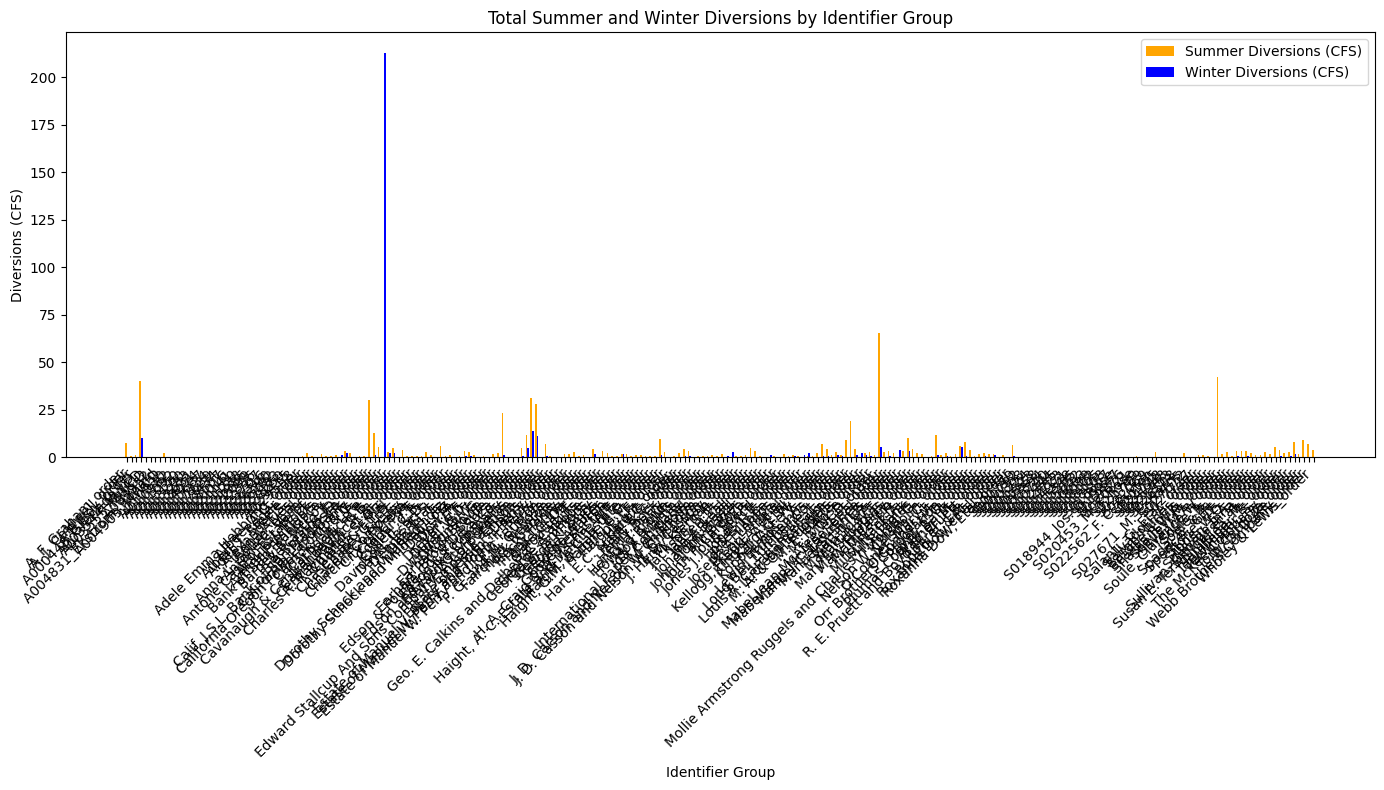

In [27]:
def save_to_excel(df, file_path, sheet_name):
    """Save a DataFrame to a specific sheet in an Excel file."""
    # Load the existing workbook
    from openpyxl import load_workbook
    book = load_workbook(file_path)
    
    # Check if the sheet already exists
    if sheet_name in book.sheetnames:
        # Remove the existing sheet
        std = book[sheet_name]
        book.remove(std)
    
    # Save the DataFrame to the new sheet
    with pd.ExcelWriter(file_path, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

# Load data and add subbasin info (if not already loaded)
gdf_landuse, gdf_streams, gdf_subbasin, gdf_irrDis, gdf_irrCan, gdf_points, df = load_data()

# Add subbasin information to the DataFrame
df = add_subbasin_info(gdf_points, gdf_subbasin, df)

# Summarize diversions by the extracted identifier group
identifier_summary = summarize_diversions_by_identifier(df)

# Save the summarized data to a new sheet named 'ID' in the Excel file
save_to_excel(identifier_summary, FILE_PATHS["excel"], "ID")

# Plot the summarized diversions by identifier group
plot_identifier_diversions(identifier_summary)

### 2.  SSWD_diverions_info/SSWD_Diversion_Info_20190503.xlsx:, Davids Engineering

In [25]:
df_sswd = pd.read_excel(FILE_PATHS["SSWD"], sheet_name='qry_Diversion_Info')
df_sswd.head()

,Decree,Service Area,Source,Diversion Number,Decree_Paragraph,Map_No,Tract_No,Parcel_No,Decreed_Owner,Priority,Owner_CFS,Summer_Period_Begin,Winter_Period_Begin,Winter_CFS,Do_Not_Report,Inactive,Inactive_Date,Inactive_Reason
0,7035,Boles Creek,unnamed spring,37,186,14,P186,060-531-440,"Kellogg, Frank A. et al",6,0.150,2018-03-01,2018-11-01,0.000,False,False,NaT,NaN
1,7035,Boles Creek,Kellogg Spring,42,188,14,P188-1,060-531-400,"Kellogg, Frank A. et al",7,0.039,2018-03-01,2018-11-01,0.016,False,False,NaT,NaN
2,7035,Boles Creek,Kellogg Spring,42,188,14,P188-2,060-552-030,"Kellogg, Frank A. et al",7,0.203,2018-03-01,2018-11-01,0.081,False,False,NaT,NaN
3,7035,Boles Creek,Kellogg Spring,42,188,14,P188-3,060-552-060,"Kellogg, Frank A. et al",7,0.008,2018-03-01,2018-11-01,0.003,False,False,NaT,NaN
4,7035,Boles Creek,Kellogg Spring,42A,189,14,P189,060-552-020,"Kellogg, Frank A. et al",17,0.025,2018-03-01,2018-11-01,0.025,False,False,NaT,NaN


##### Mapping SSWD with the Parcels shapefile 

In [30]:
column = 'Parcel_No' # This is the excel column name that contains the parcel number
APN= 'PARCEL_APN' # this is the column name in the shapefile that contains the parcel number
gdf_parcels = gpd.read_file(parcel)
df_sswd = pd.read_excel(SSWD, sheet_name=sheetname)

# Merge the shapefile and Excel data based on the parcel number
merged_gdf = gdf_parcels.merge(df_sswd, left_on=APN, right_on=column, how='left')

# Identify unmatched parcels
unmatched_parcels = df_sswd[~df_sswd[column].isin(gdf_parcels[APN])]

# Save unmatched parcels to a new sheet in the original Excel file
with pd.ExcelWriter(SSWD, mode='a', engine='openpyxl') as writer:
      unmatched_parcels.to_excel(writer, sheet_name='No_match', index=False)

# Save the merged GeoDataFrame to the same shapefile
merged_gdf.to_file(parcel, driver='ESRI Shapefile')

print(f"Merged shapefile saved to {parcel}")
print(f"Unmatched parcels saved to 'No_match' sheet in {SSWD}")

C:\Users\bisrat\AppData\Local\Temp\ipykernel_21508\2740227331.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(parcel, driver='ESRI Shapefile')
c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Service Area' to 'Service Ar'
  ogr_write(
c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Diversion Number' to 'Diversion'
  ogr_write(
c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Decree_Paragraph' to 'Decree_Par'
  ogr_write(
c:\Users\bisrat\Desktop\Shasta_project\SWBM_shasta\visualizing_SWBM\.conda\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered fi

Merged shapefile saved to D:/Shasta/20250130_diversions/DiversionGIS/i15ParcelsAssessorLightbox.shp
Unmatched parcels saved to 'No_match' sheet in D:/Shasta/20250130_diversions/SSWD_diverions_info/SSWD_Diversion_Info_20190503.xlsx


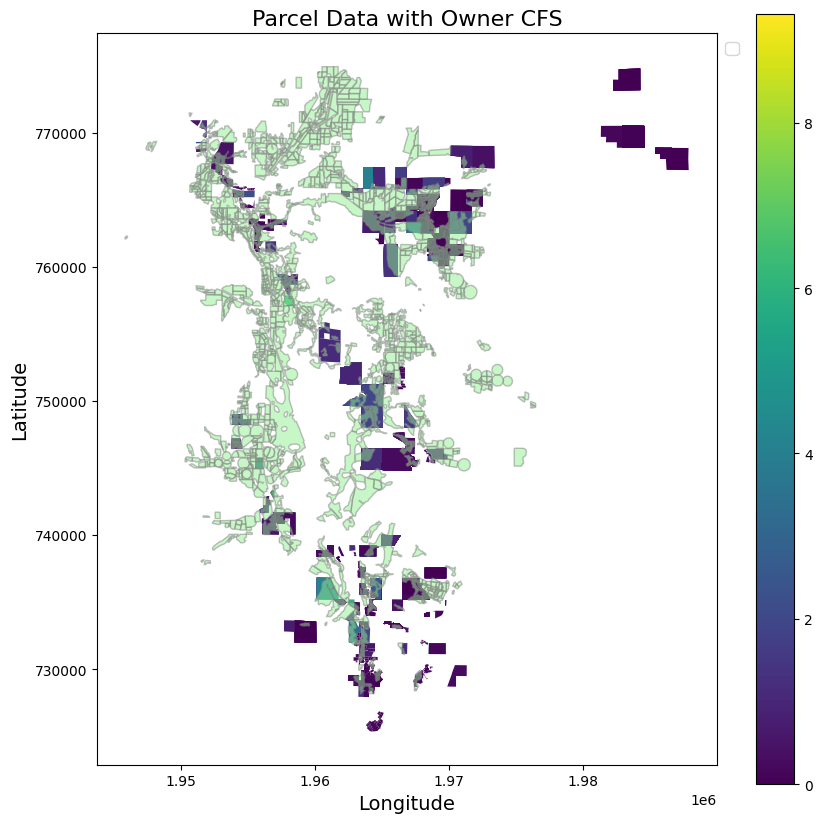

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the merged GeoDataFrame
merged_gdf.plot(ax=ax, column='Owner_CFS', legend=True, cmap='viridis')
# Plot the landuse layer
gdf_landuse.plot(ax=ax, color='lightgreen', edgecolor='gray', alpha=0.5, label='Land Use')
# Add title and labels
plt.title('Parcel Data with Owner CFS', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

# Show the plot
plt.show()

### 3.  Diversion summerzide by water master: Shasta_Valley_Surface_Diversion_Summary 191114

In [43]:
df_davids = pd.read_excel(FILE_PATHS["Davids"], sheet_name='Aggregated')
df_davids.head()

,Year Type,Season,Water Year,Month,Upper Shasta,Lower Shasta,Little Shasta,Parks Creek,Boles Creek,Beaughan Creek,Carrick Creek,Jackson Creek,Total
0,Normal,Winter,2015,2014-11-01,18.300,10.85,21.930,18.330,13.98,4.47,1.390,0.38,89.630
1,Normal,Winter,2015,2014-12-01,18.300,10.85,21.930,18.330,13.98,4.47,1.390,0.38,89.630
2,Normal,Winter,2015,2015-01-01,18.300,10.85,21.930,18.330,13.98,4.47,1.390,0.38,89.630
3,Normal,Winter,2015,2015-02-01,18.300,10.85,21.930,18.330,13.98,4.47,1.390,0.38,89.630
4,Normal,Irrigation,2015,2015-03-01,106.185,136.64,29.872,55.655,35.36,10.30,11.722,3.05,388.784


##### -- Plot summary of the diversion

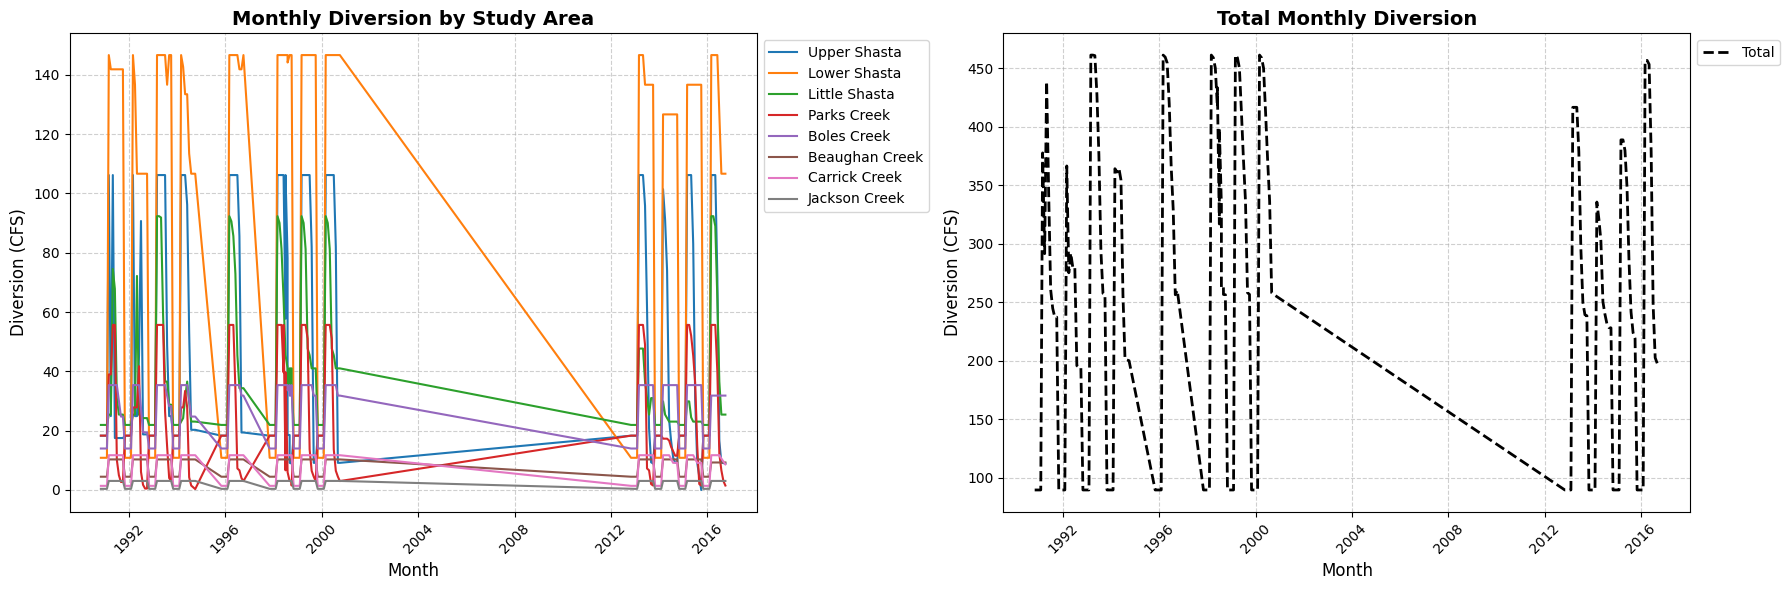

In [44]:

# Convert 'Month' column to datetime
df_davids['Month'] = pd.to_datetime(df_davids['Month'], format='%B %Y')

# Sort the data by the 'Month' column
df_davids = df_davids.sort_values(by='Month')

# Set 'Month' as the index for easier plotting
df_davids.set_index('Month', inplace=True)

# List of areas to plot
areas = [
    'Upper Shasta', 'Lower Shasta', 'Little Shasta', 'Parks Creek',
    'Boles Creek', 'Beaughan Creek', 'Carrick Creek', 'Jackson Creek'
]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: All study areas
for area in areas:
    ax1.plot(df_davids.index, df_davids[area], label=area)

# Add details for the first subplot
ax1.set_title('Monthly Diversion by Study Area', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Diversion (CFS)', fontsize=12)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)  # Move legend outside
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot 2: Total diversion
ax2.plot(df_davids.index, df_davids['Total'], color='black', linewidth=2, linestyle='--', label='Total')

# Add details for the second subplot
ax2.set_title('Total Monthly Diversion', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Diversion (CFS)', fontsize=12)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)  # Move legend outside
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()